In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

import albumentations as A

print("hello world")



hello world


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from torchsummary import summary
import pandas as pd
import numpy as np
from skimage.io import imread, imsave
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

In [4]:

#step2
data_dir  = 'C:/Users/rajam/OneDrive/Desktop/imgdataset/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [5]:

#step 3
#Responsible for converting images (resizing and adding it to folder)
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)),  transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),

    transforms.RandomRotation(degrees=15),

    transforms.ColorJitter(),

    transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),

    transforms.CenterCrop(size=256),  transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])





dataset = ImageFolder(data_dir, transform = transformations)
print("completed step 3")



completed step 3


In [6]:
dataset.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [7]:
#step 12
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        """
        F.poisson_nll_loss
        F.cross_entropy
        F.gaussian_nll_loss
        F.kl_div
        F.nll_loss
        """
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))
        
print("step 12 completed")

step 12 completed


In [10]:
#step 13

class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

#softmax()
print("step 13 completed")

step 13 completed


In [12]:
PATH = 'C:/Users/rajam/OneDrive/Desktop/college project/Code/projectreview1/resnet50_b64_aug_nadam23.pth'

#resnet34AdamB64_801010.pth

#resnet50_b64_aug_nadam23.pth
#the_model = TheModelClass(*args, **kwargs)
the_model = ResNet()

the_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
the_model.eval()

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [14]:
from PIL import Image
from pathlib import Path

In [15]:
trans_test = transforms.Compose([
     transforms.Resize((300, 300)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
     ])




In [16]:
#step 14
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (type(list),type(tuple))):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

    
    
print("step 14 completed")

step 14 completed


In [17]:
device = get_default_device()
print(device)
print("step 15 completed")

cpu
step 15 completed


In [18]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles glass.


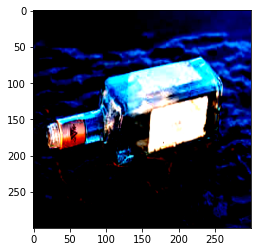

In [19]:


#def predict_external_image1(image_name):
image = Image.open(Path('C:/Users/rajam/OneDrive/Desktop/college project/Code/projectreview1/images/glass.jpg'))

example_image = trans_test(image)
plt.imshow(example_image.permute(1, 2, 0))
print("The image resembles", predict_image(example_image, the_model) + ".")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles cardboard.


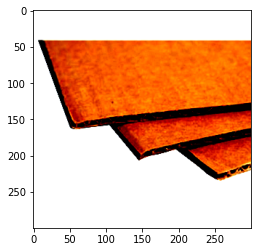

In [20]:


#def predict_external_image1(image_name):
image = Image.open(Path('C:/Users/rajam/OneDrive/Desktop/college project/Code/projectreview1/images/cb1.jpg'))

example_image = trans_test(image)
plt.imshow(example_image.permute(1, 2, 0))
print("The image resembles", predict_image(example_image, the_model) + ".")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles cardboard.


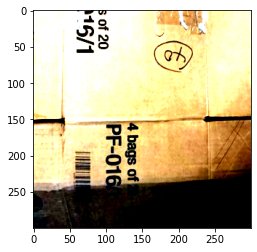

In [21]:
#def predict_external_image1(image_name):
image = Image.open(Path('C:/Users/rajam/OneDrive/Desktop/college project/Code/projectreview1/images/cardboard3.jpg'))

example_image = trans_test(image)
plt.imshow(example_image.permute(1, 2, 0))
print("The image resembles", predict_image(example_image, the_model) + ".")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles metal.


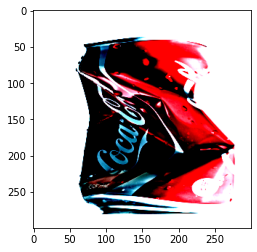

In [22]:
#def predict_external_image1(image_name):
image = Image.open(Path('C:/Users/rajam/OneDrive/Desktop/college project/Code/projectreview1/images/tincan.jpg'))

example_image = trans_test(image)
plt.imshow(example_image.permute(1, 2, 0))
print("The image resembles", predict_image(example_image, the_model) + ".")


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
completed step 3
completed step 8
correct_prediction_count :  124
incorrect_prediction_count :  5
total test data :  129
Accuracy :  96.12403100775194
Confusion matrix : 
[[20  0  0  0  0  0]
 [ 0 21  0  0  1  0]
 [ 0  0 22  0  0  0]
 [ 0  0  0 23  0  0]
 [ 2  0  0  0 20  0]
 [ 1  0  0  1  0 18]]


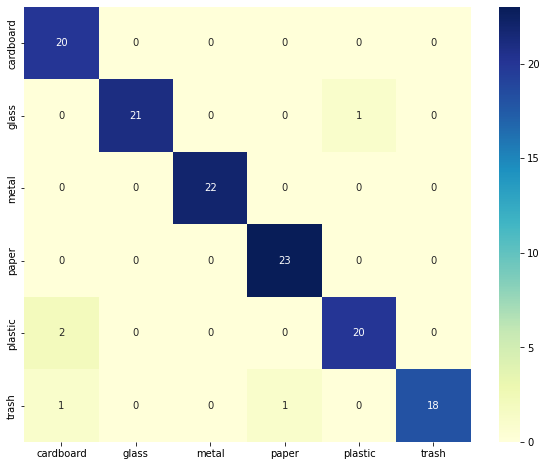

In [34]:
model = the_model


data_dir  = 'C:/Users/rajam/OneDrive/Desktop/college project/Test_data/'

classes = os.listdir(data_dir)
print(classes)


from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
transformations = transforms.Compose([transforms.Resize((256, 256)),
                                   transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
dataset = ImageFolder(data_dir,transform = transformations)
print("completed step 3")

test_ds = dataset
#train_ds, val_ds, test_ds = random_split(dataset, [0,0, 120])

from torch.utils.data.dataloader import DataLoader
batch_size = 64
print("completed step 8")

test_dl = DataLoader(dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)


#predict()

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Actual Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

    
def accuracy_calculation():
    #x = ['']*len(test_ds)
    #xp = ['']*len(test_ds)
    x=[]
    xp=[]
    correct_prediction_count = 0
    incorrect_prediction_count = 0
    waste_types = ['cardboard','glass','metal','paper','plastic','trash']
    #predictions = [predict_image(x,loaded_model) for x in test_ds]
    for y in range(0,len(test_ds)):
        img, label = test_ds[y]
        #img, label = dataset[12]
        #show_sample(img, label)
        actual = dataset.classes[label]
        prediction = predict_image(img, model)
        #print("Predicted Label : "+prediction + ".")
        #print(predictions[y])
        x.append(actual)
        xp.append(prediction)
        if(actual == prediction):
            correct_prediction_count = correct_prediction_count+1
        else:
            incorrect_prediction_count = incorrect_prediction_count+1
        
    accuracy = (correct_prediction_count/len(test_ds))*100
    print("correct_prediction_count : ",correct_prediction_count)
    print("incorrect_prediction_count : ",incorrect_prediction_count)
    print("total test data : ",len(test_ds))
    print("Accuracy : ",accuracy)
    
    
    
    cm = confusion_matrix(x,xp)
    print("Confusion matrix : ")
    print(cm)
    
    df_cm = pd.DataFrame(cm,waste_types,waste_types)

    plt.figure(figsize=(10,8))
    sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")
    
    
accuracy_calculation()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles glass.


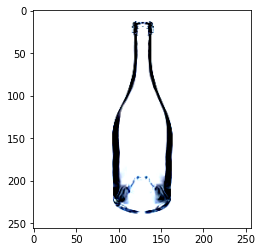

In [33]:
image = Image.open(Path('C:/Users/rajam/OneDrive/Desktop/college project/Test_data/glass/g2.jpg'))
#C:\Users\rajam\OneDrive\Desktop\college project\Test_data\metal
example_image = transformations(image)
plt.imshow(example_image.permute(1, 2, 0))
print("The image resembles", predict_image(example_image, the_model) + ".")